# Data Analysis

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [160]:
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
blue = '#7995c4'
orange = 'orange'

Something here, just make pretty later

In [161]:
orgs_df = pd.read_csv('clean_data/organizations.csv').drop(columns='Unnamed: 0')
people_df = pd.read_csv('clean_data/people.csv').drop(columns='Unnamed: 0')
rounds_df = pd.read_csv('clean_data/rounds.csv').drop(columns='Unnamed: 0')

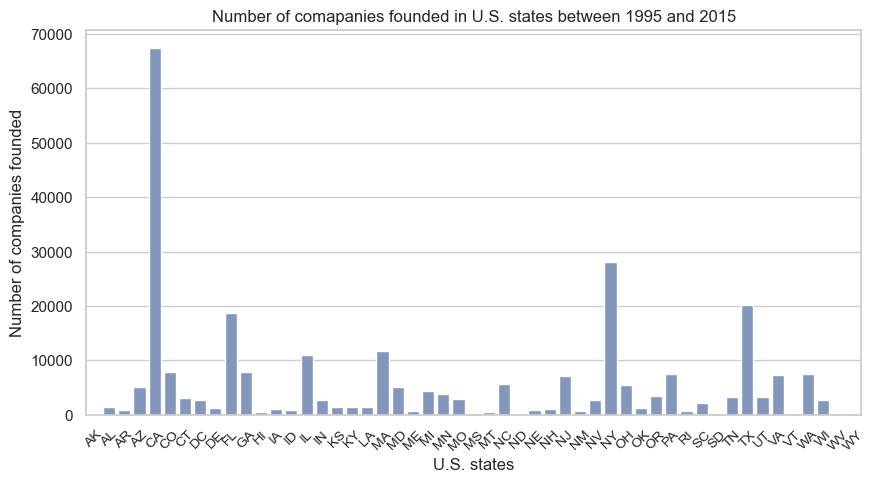

In [162]:
# Create a bar plot for companies per state

to_plot_states = orgs_df.groupby(by='state_code').count().reset_index()[['state_code','uuid']][1:]
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax = sns.barplot(x="state_code", y="uuid", data=to_plot_states,color=blue)
ax.set_xticklabels(to_plot_states["state_code"],rotation=45,fontsize=10)

ax.set_ylabel('Number of companies founded')
ax.set_xlabel('U.S. states')
ax.set_title('Number of comapanies founded in U.S. states between 1995 and 2015')

plt.show()

In [163]:
# Get only companies in California
orgs_df = orgs_df[orgs_df['state_code'] == 'CA'].drop(columns='state_code').rename(columns={'uuid':'org_uuid'})

# The companies that have a nan-entry in Series B have not gone through this round
cond = rounds_df['investment_type_series_b'].fillna(False).astype(bool)
series_b = rounds_df[cond][['org_uuid','investment_type_series_b']]

# Add a series_B column to orgs_df
orgs_df = orgs_df.merge(series_b,how='left',on='org_uuid')
orgs_df['investment_type_series_b'] = orgs_df['investment_type_series_b'].fillna(False).astype(bool)


# Define what success mean in our experiment
cond1 = (orgs_df['status'] == 'acquired') | (orgs_df['status'] == 'ipo')
cond2 = (orgs_df['status'] == 'operating') & orgs_df['investment_type_series_b']
orgs_df['success'] = cond1 | cond2


In [164]:
num_sucessful = orgs_df['success'].sum()
num_failed = orgs_df['success'].count() - num_sucessful

print(f'There is a total of {num_sucessful + num_failed} of companies founded in california between 1995 and 2015')
print(f'Out of that number, {num_sucessful} companies were successful while {num_failed} failed')

There is a total of 67469 of companies founded in california between 1995 and 2015
Out of that number, 8569 companies were successful while 58900 failed


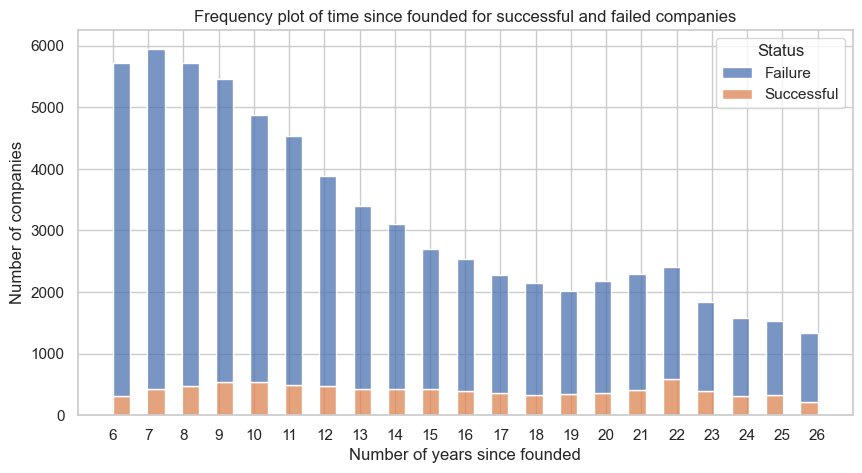

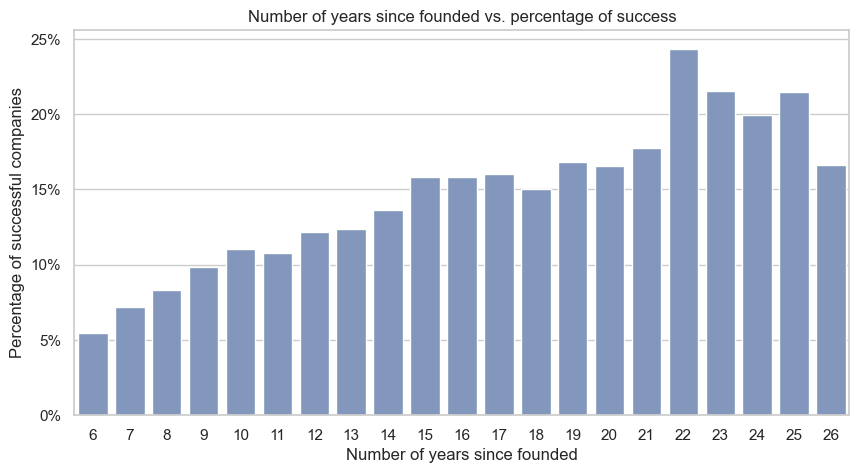

In [165]:
# plot graphs of company success since founded
orgs_df['founded_on'] = pd.to_datetime(orgs_df['founded_on'])
to_plot = orgs_df[['org_uuid','founded_on','success']] 

to_plot['years_since_found'] = (2021 - to_plot['founded_on'].dt.year).astype(int)
to_plot['Status'] = to_plot['success'].map(lambda x: 'Successful' if x else 'Failure')

# Absolute histogram
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax = sns.histplot(x="years_since_found",data=to_plot,multiple="stack",hue='Status')

ax.set_xticks(range(6,27))
ax.set_ylabel('Number of companies')
ax.set_xlabel('Number of years since founded')
ax.set_title('Frequency plot of time since founded for successful and failed companies')

plt.show()
# Save plot here

# Get proportions of success per year so we can plot
temp = to_plot[['years_since_found','Status','org_uuid']].groupby(by=['years_since_found','Status'],).count()
totals = temp.groupby(level=0).sum().reset_index().rename(columns={'org_uuid':'count_total'})
success = temp.loc[(slice(None),'Successful'),:].reset_index().drop(columns='Status').rename(columns={'org_uuid':'count_succ'})
to_plot = success.merge(totals,how='inner',on='years_since_found') 
to_plot['proportion_success'] = to_plot['count_succ'] / to_plot['count_total']

# relative histogram
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax = sns.barplot(x="years_since_found",y='proportion_success',data=to_plot,color=blue)

ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%', '25%'])
ax.set_ylabel('Percentage of successful companies')
ax.set_xlabel('Number of years since founded')
ax.set_title('Number of years since founded vs. percentage of success')

plt.show()

In [166]:
# Plot graphs for category groups
temp = orgs_df['category_groups_list'].map(lambda entry: str(entry).split(','))
dummies = pd.get_dummies(temp.apply(pd.Series).stack()).sum(level=0).iloc[:,:-1]

In [167]:
# Grouping values below frequency
# Find categories we will label as others
median_thres = dummies.sum(axis=0).median()
a = dummies.sum(axis=0) < median_thres
others = a.where(a).dropna().index.to_list()

def label_other(lst):
    ans = []
    for item in lst:
        if item in others:
            if item == 'Other': pass
            else: ans.append('Other')
        else: ans.append(item)
    return ans
            
label_other = lambda lst: ['Other' if item in others else item for item in lst]
temp = temp.map(label_other)
new_dummies = pd.get_dummies(temp.apply(pd.Series).stack()).sum(level=0).iloc[:,:-1]
new_dummies = pd.concat([orgs_df['org_uuid'],new_dummies],axis=1)

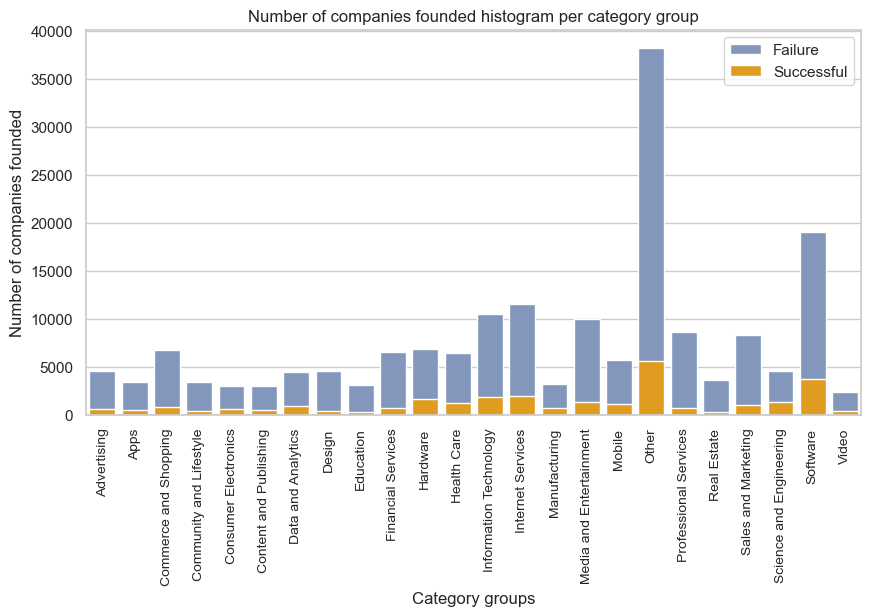

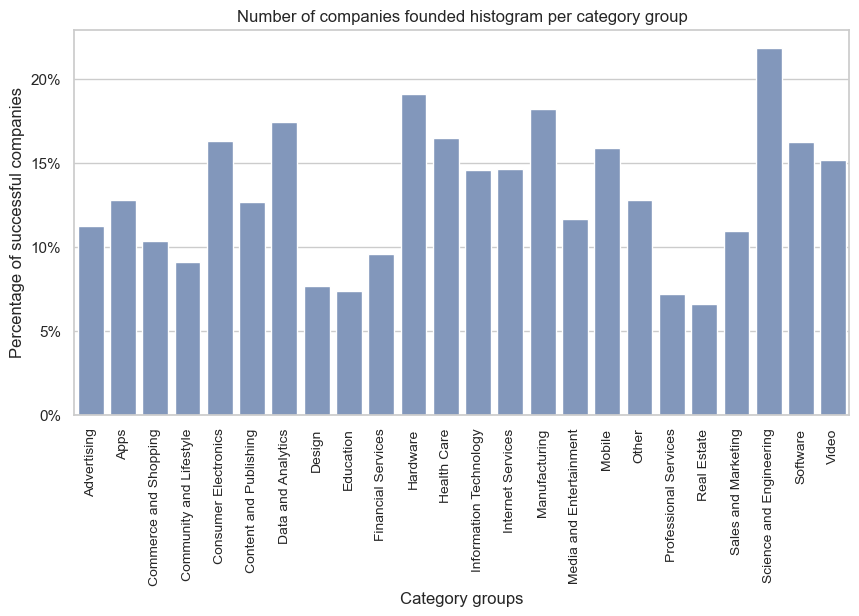

In [168]:
# Create a bar plot for companies per category
to_plot = pd.concat([orgs_df[['success']],new_dummies],axis=1)
to_plot['Status'] = to_plot['success'].map(lambda x: 'Successful' if x else 'Failure')
to_plot = to_plot.groupby(by='Status').sum().drop(columns='success')\
                                      .transpose().reset_index()\
                                      .rename(columns={'index':'Category'})

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax1 = sns.barplot(x='Category',y='Failure',data=to_plot,color=blue,label='Failure')
ax2 = sns.barplot(x='Category',y='Successful',data=to_plot,color=orange,label='Successful')

ax.set_xticklabels(to_plot['Category'],rotation=90,fontsize=10)

ax.set_ylabel('Number of companies founded')
ax.set_xlabel('Category groups')
ax.set_title('Number of companies founded histogram per category group')
ax.legend()

plt.show()
# Save plot

# Get proportions of success per category so we can plot
totals = to_plot.sum(axis=1)
to_plot['Percentange_success'] = to_plot['Successful'] / totals

# relative histogram
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax = sns.barplot(x="Category",y='Percentange_success',data=to_plot,color=blue)

ax.set_xticklabels(to_plot['Category'],rotation=90,fontsize=10)
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])
ax.set_ylabel('Percentage of successful companies')
ax.set_xlabel('Category groups')
ax.set_title('Number of companies founded histogram per category group')

plt.show()
# Save plot

In [169]:
# Get ceo and founders dataframes
founders_df = people_df[people_df['is_founder']]
founders_df['first_venture_on'] = pd.to_datetime(founders_df['first_venture_on'])
founders_df['first_deg_completed_date'] = pd.to_datetime(founders_df['first_deg_completed_date'])

curr_ceo_df = people_df[people_df['is_current_ceo']]

# Clean ceo information
curr_ceo_df = curr_ceo_df.groupby(by=['org_uuid']).agg({'num_degs_attempted':'sum',
                                                        'num_degs_finished':'sum'})\
                                    .reset_index()\
                                    .rename(columns={'num_degs_attempted':'num_degs_attempted_by_curr_ceo',
                                                     'num_degs_finished':'num_degs_finished_by_curr_ceo'})

# Clean founders info
founders_df = founders_df.groupby(by=['org_uuid']).agg({'number_founded':'max',
                                                        'num_degs_attempted':'mean',
                                                        'num_degs_finished':'mean',
                                                        'veteran_founder':'max',
                                                        'first_venture_on':'min',
                                                        'first_deg_completed_date':'min'})\
                                                  .rename(columns={'number_founded':'max_number_founded_by_one_founder',
                                                                   'num_degs_attempted':'avg_num_degs_attempted_by_founders',
                                                                   'num_degs_finished':'avg_num_degs_finished_by_founders',
                                                                   'veteran_founder':'at_least_one_veteran_founder',
                                                                   'first_venture_on':'oldest_founder_first_venture_on',
                                                                   'first_deg_completed_date':'oldest_founder_deg_completed_date'})

# Expand orgs_df and include new columns
temp = orgs_df.merge(curr_ceo_df,how='left',on='org_uuid')
full_orgs_df = temp.merge(founders_df,how='left',on='org_uuid')

# Get years between two degrees
full_orgs_df['years_between_degree_founding'] = full_orgs_df['founded_on'].apply(lambda x: x.year) - full_orgs_df['oldest_founder_deg_completed_date'].apply(lambda x: x.year)
full_orgs_df['years_between_first_curr_founding'] = full_orgs_df['founded_on'].apply(lambda x: x.year) - full_orgs_df['oldest_founder_first_venture_on'].apply(lambda x: x.year)

# All negatives should be zero
full_orgs_df['years_between_degree_founding'] = full_orgs_df['years_between_degree_founding'].map(lambda x: 0 if x <= 0 else x)
full_orgs_df['years_between_first_curr_founding'] = full_orgs_df['years_between_first_curr_founding'].map(lambda x: 0 if x <= 0 else x)

# Drop useless columns
full_orgs_df = full_orgs_df.drop(columns=['category_list','status','last_funding_on','oldest_founder_deg_completed_date',\
                                          'investment_type_series_b','oldest_founder_first_venture_on'])

In [170]:
def create_counts_missing(full_orgs_df):

    counts_missing = pd.concat([full_orgs_df.isna().count(), full_orgs_df.isna().sum()],axis=1)
    counts_missing = counts_missing.rename(columns={0:'Count',1:'Missing values'})
    counts_missing['Complete values'] = counts_missing['Count'] - counts_missing['Missing values']

    return counts_missing

create_counts_missing(full_orgs_df)

,Count,Missing values,Complete values
org_uuid,67469,0,67469
category_groups_list,67469,722,66747
founded_on,67469,0,67469
success,67469,0,67469
num_degs_attempted_by_curr_ceo,67469,62409,5060
num_degs_finished_by_curr_ceo,67469,62409,5060
max_number_founded_by_one_founder,67469,55153,12316
avg_num_degs_attempted_by_founders,67469,55153,12316
avg_num_degs_finished_by_founders,67469,55153,12316
at_least_one_veteran_founder,67469,55153,12316


In [171]:
# Inpute 

# If the category entry is Nan, then we can assume they belong to 'other'
full_orgs_df['category_groups_list'] = full_orgs_df['category_groups_list'].fillna('Other')

# If they CEO have a nan entry, we assume they have no degrees
full_orgs_df['num_degs_attempted_by_curr_ceo'] = full_orgs_df['num_degs_attempted_by_curr_ceo'].fillna(0)
full_orgs_df['num_degs_finished_by_curr_ceo'] = full_orgs_df['num_degs_finished_by_curr_ceo'].fillna(0)

# If they founders have NaN previous startups, we assume they have none
full_orgs_df['max_number_founded_by_one_founder'] = full_orgs_df['max_number_founded_by_one_founder'].fillna(0)
full_orgs_df['at_least_one_veteran_founder'] = full_orgs_df['at_least_one_veteran_founder'].fillna(0)

# If founders have nan entry in titles, we assume they have no degrees
full_orgs_df['avg_num_degs_attempted_by_founders'] = full_orgs_df['avg_num_degs_attempted_by_founders'].fillna(0)
full_orgs_df['avg_num_degs_finished_by_founders'] = full_orgs_df['avg_num_degs_finished_by_founders'].fillna(0)

# We know that 'years between...' is a proxy for experience. The more years, the more experience.
# Hence, makes sense to replace NaNs with 0
full_orgs_df['years_between_degree_founding'] = full_orgs_df['years_between_degree_founding'].fillna(0)
full_orgs_df['years_between_first_curr_founding'] = full_orgs_df['years_between_first_curr_founding'].fillna(0)

In [172]:
create_counts_missing(full_orgs_df)

,Count,Missing values,Complete values
org_uuid,67469,0,67469
category_groups_list,67469,0,67469
founded_on,67469,0,67469
success,67469,0,67469
num_degs_attempted_by_curr_ceo,67469,0,67469
num_degs_finished_by_curr_ceo,67469,0,67469
max_number_founded_by_one_founder,67469,0,67469
avg_num_degs_attempted_by_founders,67469,0,67469
avg_num_degs_finished_by_founders,67469,0,67469
at_least_one_veteran_founder,67469,0,67469


In [173]:
def create_two_plots(column_name,x_label,round_means=False,exclude_second=False,save=False):
    
    to_plot = full_orgs_df
    
    if round_means:
        to_plot[column_name] = to_plot[column_name].map(lambda x: round(x),na_action='ignore')
    
    to_plot['Success'] = to_plot['success'].map(lambda x: 'Successful' if x else 'Failure')

    fig, ax = plt.subplots(1,1, figsize=(10,5))

    sns.histplot(data=to_plot,x=column_name,hue='Success',multiple='stack')

    ax.set_ylabel('Number of companies')
    ax.set_xlabel(x_label)
    ax.set_title(f'Histogram of companies by the {x_label.lower()}')

    plt.show()

    if exclude_second:
        return ''
    
    # Get proportions of success
    temp = to_plot[['Success',column_name,'org_uuid']]\
                  .groupby(by=[column_name,'Success']).count()

    totals = temp.groupby(level=0).sum().reset_index().rename(columns={'org_uuid':'count_total'})
    success = temp.loc[(slice(None),'Successful'),:].reset_index().rename(columns={'org_uuid':'count_succ'})
    to_plot_prop = success.merge(totals,how='inner',on=column_name) 
    to_plot_prop['proportion_success'] = to_plot_prop['count_succ'] / to_plot_prop['count_total']

    # relative histogram
    fig, ax = plt.subplots(1,1, figsize=(10,5))

    ax = sns.barplot(x=column_name,y='proportion_success',data=to_plot_prop,color=blue)

    ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%'])
    ax.set_ylabel('Percentage of successful companies')
    ax.set_xlabel(x_label)
    ax.set_title(f'Percetage of companies by the {x_label.lower()}')

    plt.show()
    # Save plot

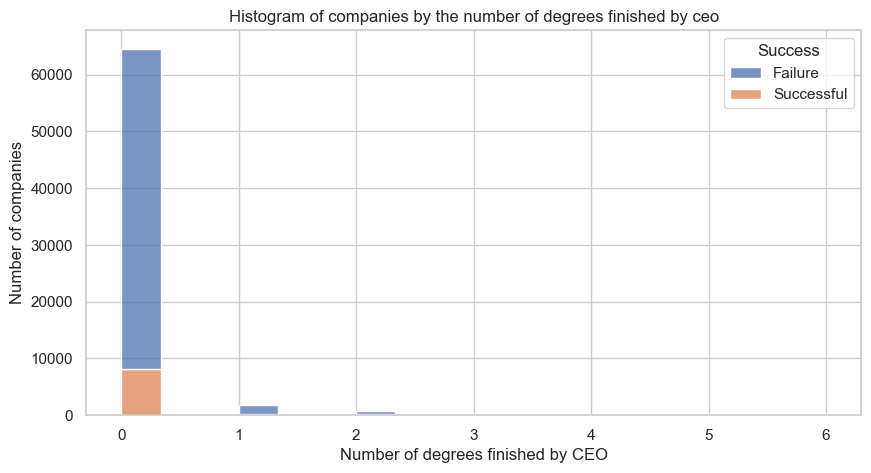

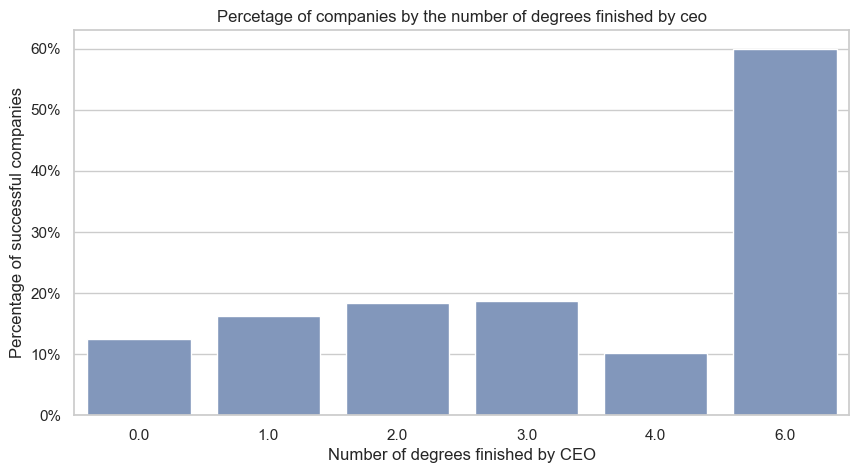

In [174]:
x_label = 'Number of degrees finished by CEO'
column_name = 'num_degs_finished_by_curr_ceo'
create_two_plots(column_name,x_label)

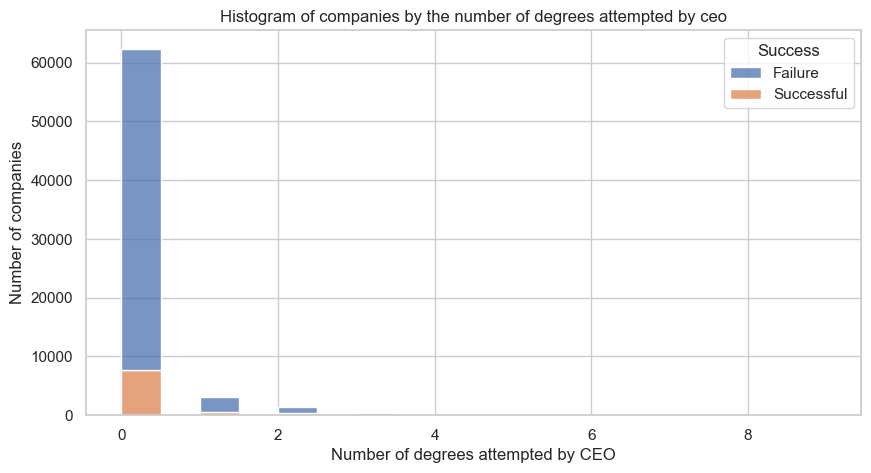

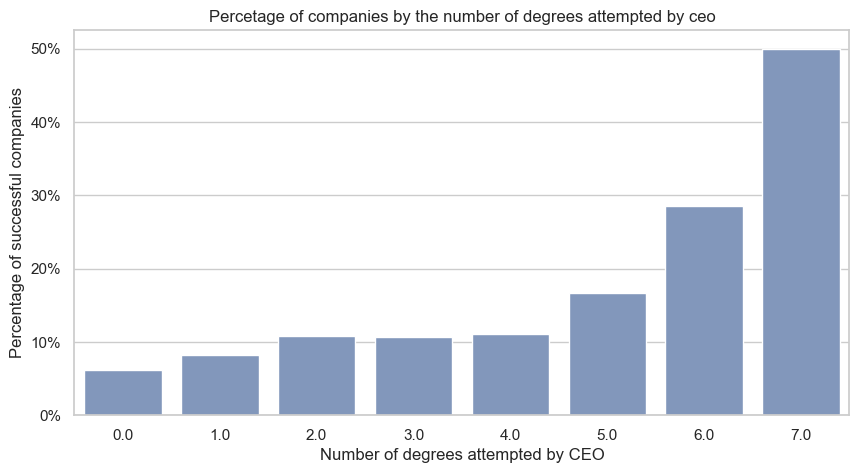

In [175]:
x_label = 'Number of degrees attempted by CEO'
column_name = 'num_degs_attempted_by_curr_ceo'
create_two_plots(column_name,x_label)

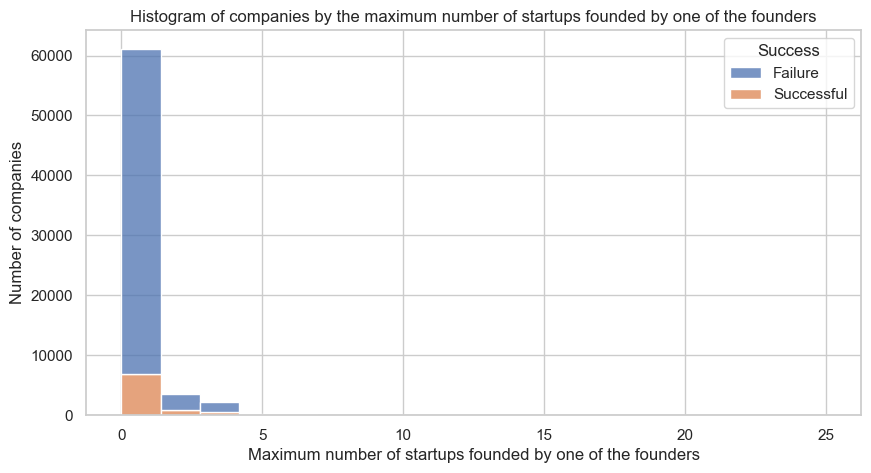

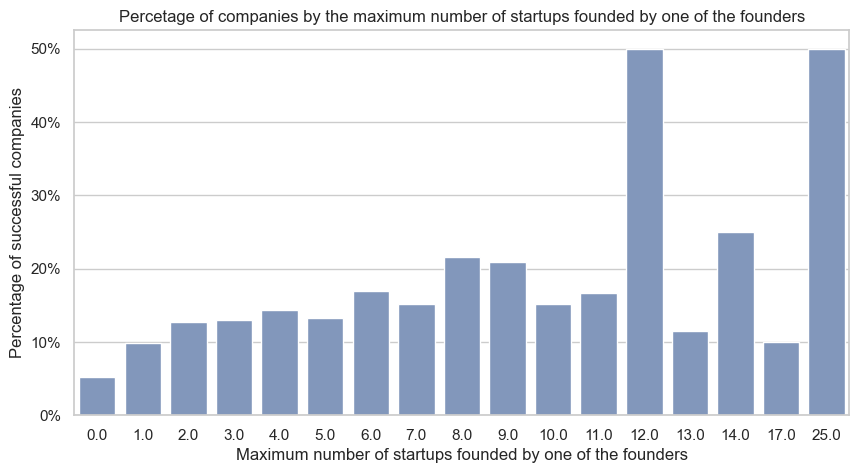

In [176]:
x_label = 'Maximum number of startups founded by one of the founders'
column_name = 'max_number_founded_by_one_founder'
create_two_plots(column_name,x_label)

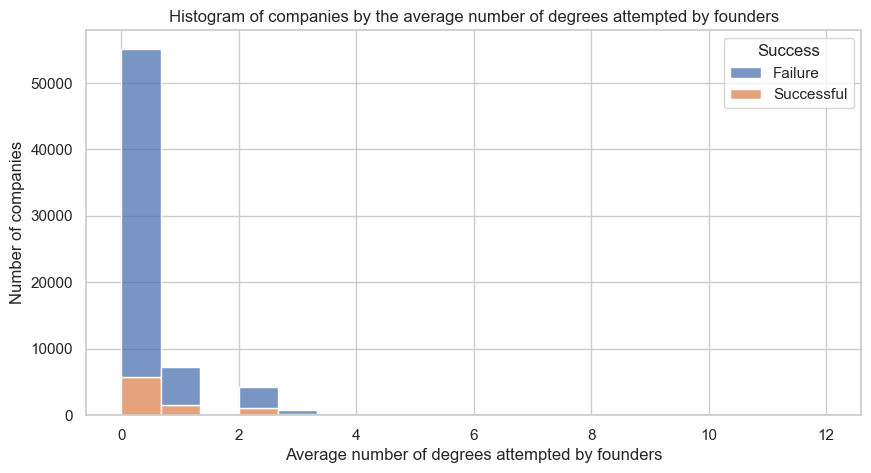

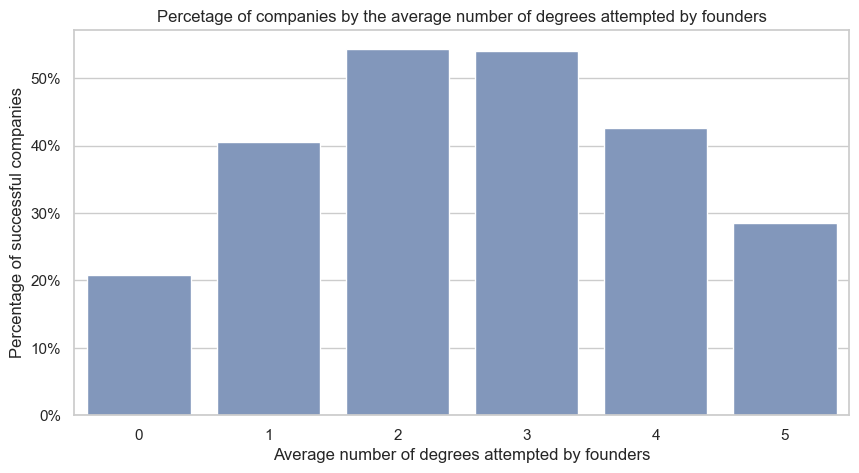

In [177]:
x_label = 'Average number of degrees attempted by founders'
column_name = 'avg_num_degs_attempted_by_founders'
create_two_plots(column_name,x_label,round_means=True)

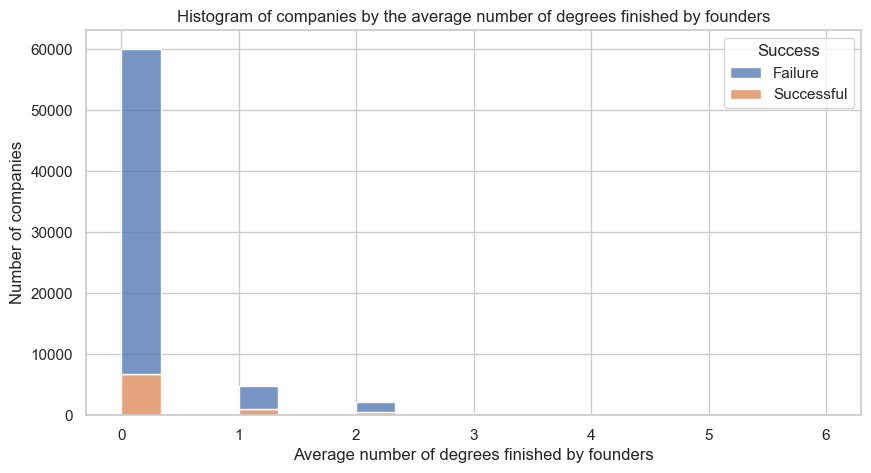

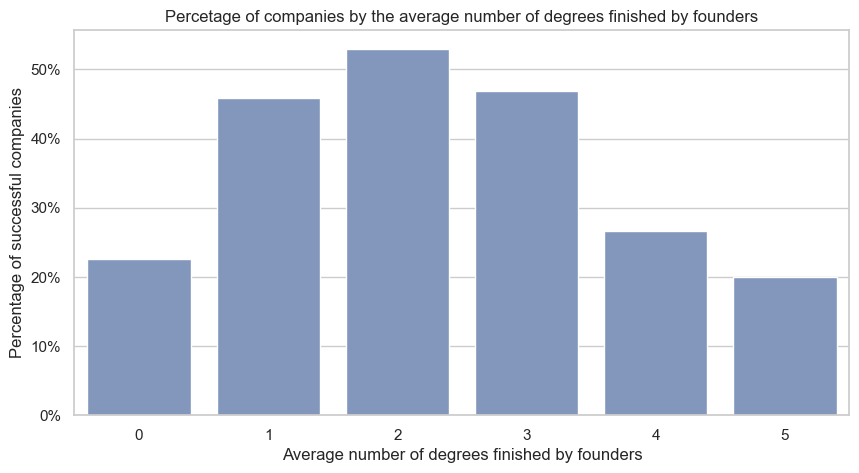

In [178]:
x_label = 'Average number of degrees finished by founders'
column_name = 'avg_num_degs_finished_by_founders'
create_two_plots(column_name,x_label,round_means=True)

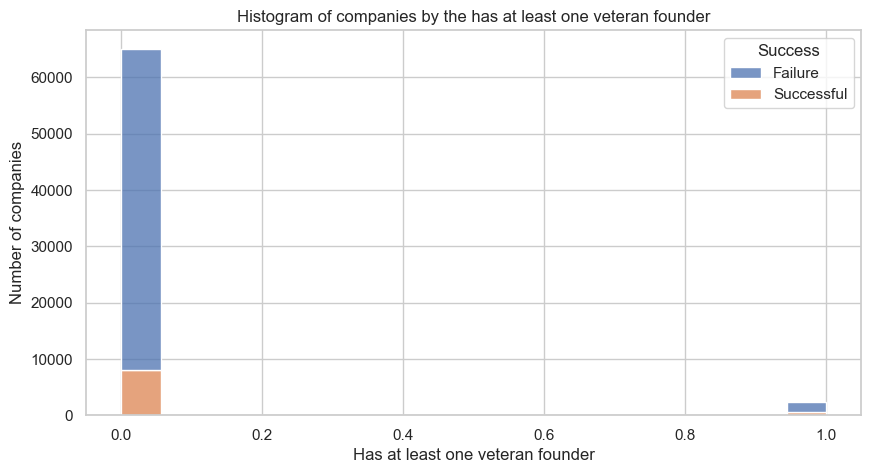

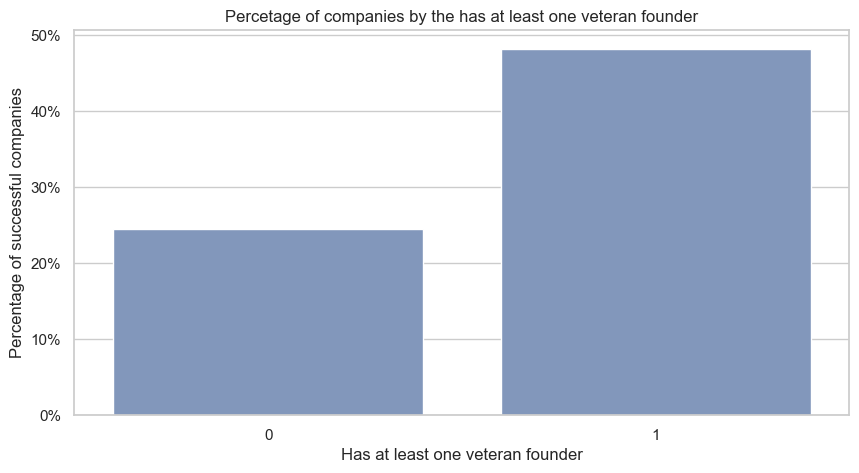

In [179]:
x_label = 'Has at least one veteran founder'
column_name = 'at_least_one_veteran_founder'
create_two_plots(column_name,x_label,round_means=True)

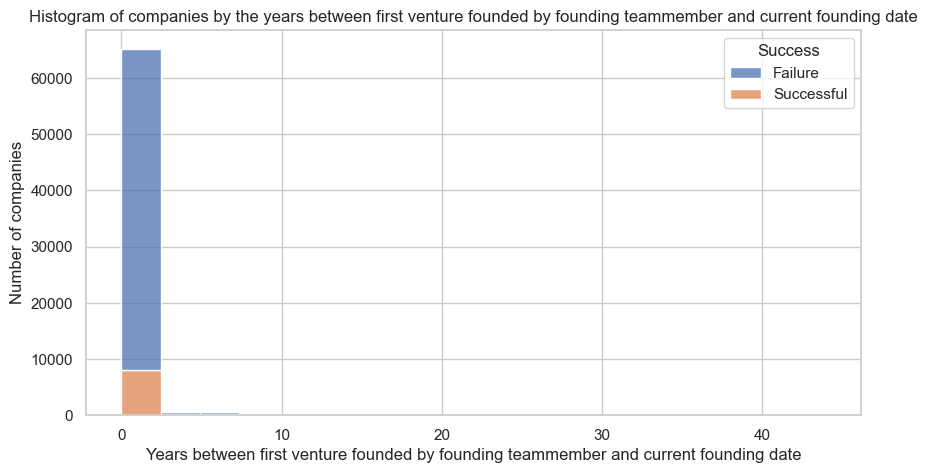

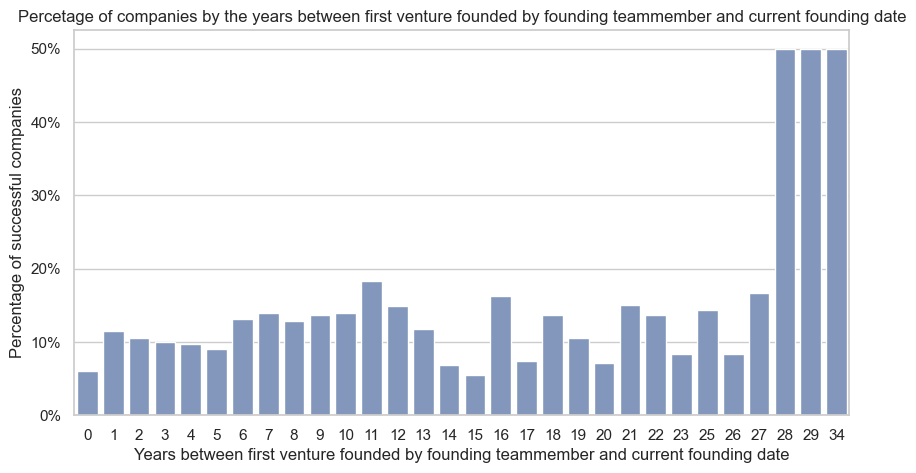

In [180]:
x_label = 'Years between first venture founded by founding teammember and current founding date'
column_name = 'years_between_first_curr_founding'
create_two_plots(column_name,x_label,round_means=True)

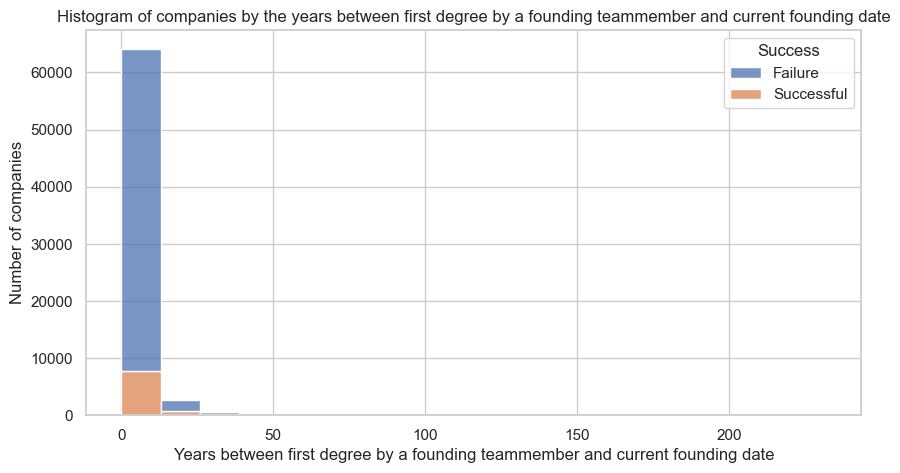

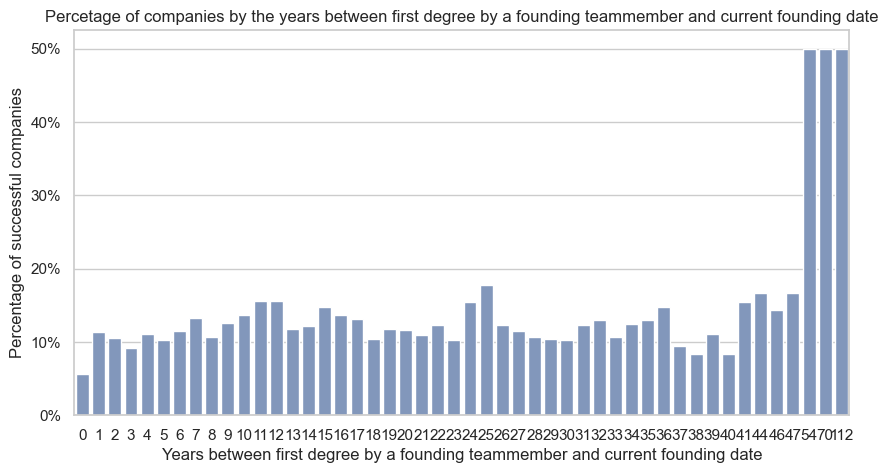

In [181]:
x_label = 'Years between first degree by a founding teammember and current founding date'
column_name = 'years_between_degree_founding'
create_two_plots(column_name,x_label,round_means=True)

In [192]:
final_df = full_orgs_df.dropna()
to_export = final_df.merge(new_dummies,how='inner',on='org_uuid').drop_duplicates()
to_export['success'] = to_export['success'].astype(int)
to_export = to_export.drop(columns=['Success','founded_on','org_uuid','category_groups_list',
                                    'num_degs_attempted_by_curr_ceo','avg_num_degs_attempted_by_founders'])
create_counts_missing(to_export)

,Count,Missing values,Complete values
success,67334,0,67334
num_degs_finished_by_curr_ceo,67334,0,67334
max_number_founded_by_one_founder,67334,0,67334
avg_num_degs_finished_by_founders,67334,0,67334
at_least_one_veteran_founder,67334,0,67334
years_between_degree_founding,67334,0,67334
years_between_first_curr_founding,67334,0,67334
Advertising,67334,0,67334
Apps,67334,0,67334
Commerce and Shopping,67334,0,67334


In [193]:
to_export.to_csv('finished_data/finish_data.csv')